In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ..

/home/osselinp/bo-on-graph


In [3]:
# test the GP cross validation
import torch
from search.trust_region import (
    restart,
)
from problems.generate_synthetic_graph import get_synthetic_problem
import matplotlib.pyplot as plt
from search.models import initialize_model
from search.utils import eigendecompose_laplacian
import networkx as nx
import gpytorch

/data/osselinp/miniconda3/envs/graph/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [82]:
seed, n, m = 0, 50, 2
g = nx.generators.random_graphs.barabasi_albert_graph(seed=seed, n=n, m=m)

In [83]:
model, _, _ = initialize_model(train_X=torch.zeros((0,1), dtype=torch.float),
                         train_Y=torch.zeros((0,1), dtype=torch.float),
                         context_graph=g,
                         covar_type="polynomial",
                         covar_kwargs = {"order": 2,})

<class 'networkx.utils.decorators.argmap'> compilation 20:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/data/osselinp/miniconda3/envs/graph/lib/python3.10/site-packages/botorch/models/gpytorch.py:119: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(


In [84]:
t = torch.tensor(range(100), dtype=torch.float).reshape(-1,1)
model.eval()
dist = model(t)

IndexError: index 50 is out of bounds for dimension 0 with size 50

tensor([[0.6932]], grad_fn=<AddBackward0>)

tensor([[-0.8912],
        [-0.2119],
        [-0.1327],
        [-0.2870],
        [-0.3938],
        [ 0.3696],
        [ 0.8259],
        [ 0.4614],
        [-1.1594],
        [-0.4147],
        [-0.4273],
        [-0.2354],
        [ 0.3810],
        [-1.0179],
        [ 0.7103],
        [-0.1335],
        [-0.2241],
        [-0.3414],
        [-1.4803],
        [-1.9124],
        [-1.3781],
        [-1.1691],
        [ 0.3582],
        [-0.1513],
        [-0.9067],
        [ 0.1273],
        [ 0.8866],
        [-1.0469],
        [-0.1105],
        [-0.3293],
        [-0.2456],
        [-1.0392],
        [ 0.2617],
        [-0.0399],
        [-0.4040],
        [-1.5658],
        [-0.3780],
        [-0.3518],
        [-0.5207],
        [ 0.4895],
        [ 0.8342],
        [-0.4345],
        [-1.1944],
        [-0.7726],
        [-0.0969],
        [-0.6721],
        [ 0.5254],
        [-0.3330],
        [-0.0982],
        [ 0.3296]])
beta: tensor([[0.6932, 0.6932, 0.6932, 0.6932, 0.

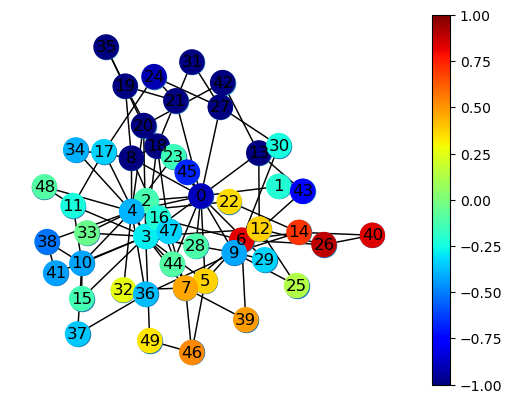

tensor([5.8457e-07, 1.1261e-01, 1.2839e-01, 1.4688e-01, 1.7074e-01, 1.9001e-01,
        2.0930e-01, 2.4383e-01, 2.6236e-01, 2.6376e-01, 2.7359e-01, 3.0031e-01,
        3.1553e-01, 3.2354e-01, 3.4242e-01, 3.7187e-01, 3.7599e-01, 4.0005e-01,
        4.1998e-01, 4.3627e-01, 4.5336e-01, 5.0000e-01, 5.0000e-01, 5.0000e-01,
        5.0000e-01, 5.0000e-01, 5.0000e-01, 5.0000e-01, 5.0000e-01, 5.3905e-01,
        5.6090e-01, 5.7087e-01, 6.0128e-01, 6.2992e-01, 6.5127e-01, 6.6171e-01,
        6.9164e-01, 6.9637e-01, 7.0663e-01, 7.2115e-01, 7.5037e-01, 7.6449e-01,
        7.7766e-01, 7.9183e-01, 8.1380e-01, 8.3791e-01, 8.5398e-01, 8.6226e-01,
        8.8028e-01, 8.9586e-01])


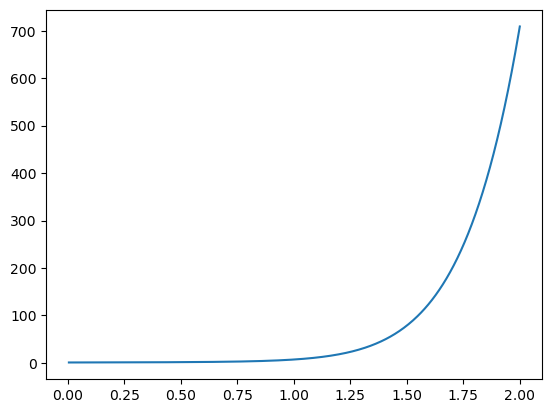

In [56]:
seed, n, m = 0, 50, 2
g = nx.generators.random_graphs.barabasi_albert_graph(seed=seed, n=n, m=m)

model, _, _ = initialize_model(train_X=torch.zeros((0,1), dtype=torch.float),
                         train_Y=torch.zeros((0,1), dtype=torch.float),
                         context_graph=g,
                         covar_type="polynomial",
                         covar_kwargs = {"order": 10,},
                         ard=True)
t = torch.tensor(range(n), dtype=torch.float).reshape(-1,1)
model.eval()
dist = model(t)
pos = nx.kamada_kawai_layout(g)
pos = nx.spring_layout(g)
nodes = g.nodes()

all_X = torch.tensor(range(n), dtype=torch.float)
t = all_X.reshape(-1,1)

model.eval()
dist = model(t)

all_Y = dist.sample().reshape(-1, 1)
print(all_Y)
print("beta:", model.covar_module.base_kernel.lengthscale)
# all_Y = eigenvecs[:, 0]
colors = all_Y
nx.draw_networkx(g, pos)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2, )
nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=colors, node_size=300, cmap=plt.cm.jet, vmin=-1,vmax=1)
plt.colorbar(nc)
plt.axis('off')
plt.savefig( "realizations10.png",bbox_inches='tight')
plt.show()


x = torch.linspace(0,2,500)[1:]
result = torch.zeros(499)
for i in range(model.covar_module.base_kernel.order):
    result += model.covar_module.base_kernel.lengthscale[0][i] * x**i
plt.plot(x.detach().numpy(), result.detach().numpy())
plt.savefig( "realizations_r10.png",bbox_inches='tight')


print(model.covar_module.base_kernel.eigenvalues)

In [105]:
dist.covariance_matrix

tensor([[ 6.9315e-01, -1.1728e-07, -2.9726e-08,  ..., -7.0564e-08,
          2.2638e-08,  2.1779e-08],
        [-1.1728e-07,  6.9315e-01,  1.0405e-07,  ..., -4.8929e-08,
         -5.6613e-08, -5.6573e-08],
        [-2.9726e-08,  1.0405e-07,  6.9315e-01,  ...,  1.3327e-07,
         -2.5398e-08,  2.4195e-08],
        ...,
        [-7.0564e-08, -4.8929e-08,  1.3327e-07,  ...,  6.9315e-01,
         -1.1289e-07,  7.8427e-09],
        [ 2.2638e-08, -5.6613e-08, -2.5398e-08,  ..., -1.1289e-07,
          6.9315e-01,  1.2802e-07],
        [ 2.1779e-08, -5.6573e-08,  2.4195e-08,  ...,  7.8427e-09,
          1.2802e-07,  6.9315e-01]], grad_fn=<AddmmBackward0>)

<class 'networkx.utils.decorators.argmap'> compilation 16:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/data/osselinp/miniconda3/envs/graph/lib/python3.10/site-packages/botorch/models/gpytorch.py:119: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(


tensor([[2.4596],
        [0.6407],
        [0.9016],
        [2.6950],
        [2.4116],
        [1.2860],
        [1.8138],
        [1.6788],
        [1.5621],
        [1.6789],
        [1.5726],
        [1.2814],
        [1.4230],
        [1.2686],
        [1.2566],
        [0.8993],
        [0.9008],
        [1.0923],
        [1.5411],
        [1.2849],
        [1.2772],
        [1.1070],
        [0.9052],
        [0.8789],
        [1.1183],
        [0.9117],
        [1.0910],
        [1.2504],
        [0.8762],
        [0.9097],
        [0.8928],
        [0.8865],
        [0.9031],
        [0.8950],
        [0.9107],
        [0.9153],
        [1.1129],
        [0.9264],
        [1.0851],
        [0.8980],
        [0.9080],
        [0.9133],
        [0.9117],
        [0.8949],
        [0.9039],
        [0.8867],
        [1.1088],
        [0.8633],
        [0.8954],
        [0.9112]])


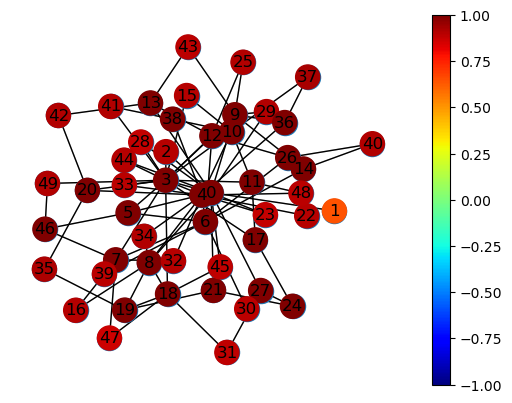

In [54]:
seed, n, m = 0, 50, 2
g = nx.generators.random_graphs.barabasi_albert_graph(seed=seed, n=n, m=m)

model, _, _ = initialize_model(train_X=torch.zeros((0,1), dtype=torch.float),
                         train_Y=torch.zeros((0,1), dtype=torch.float),
                         context_graph=g,
                         covar_type="polynomial",
                         covar_kwargs = {"order": 2,})
t = torch.tensor(range(n), dtype=torch.float).reshape(-1,1)
model.eval()
dist = model(t)
pos = nx.kamada_kawai_layout(g)
pos = nx.spring_layout(g)
nodes = g.nodes()

all_X = torch.tensor(range(n), dtype=torch.float)
t = all_X.reshape(-1,1)
model.eval()
dist = model(t)

all_Y = dist.sample().reshape(-1, 1)
print(all_Y)
# all_Y = eigenvecs[:, 0]
colors = all_Y
nx.draw_networkx(g, pos)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2, )
nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=colors, node_size=300, cmap=plt.cm.jet, vmin=-1,vmax=1)
plt.colorbar(nc)
plt.axis('off')
plt.savefig( "realizations2.pdf",bbox_inches='tight')
plt.savefig( "realizations2.png",bbox_inches='tight')
plt.show()

tensor([[-0.0924],
        [-0.0421],
        [-0.0459],
        [-0.0708],
        [-0.4633],
        [ 0.4082],
        [ 0.3633],
        [ 0.6080],
        [ 0.0238],
        [-1.5559],
        [-0.7237],
        [ 0.3968],
        [-0.2341],
        [-0.0075],
        [-0.7678],
        [-0.4253],
        [ 0.2596],
        [ 0.8520],
        [ 0.1286],
        [ 0.2676],
        [ 0.3148],
        [ 0.6179],
        [-0.4600],
        [-0.1023],
        [ 1.2059],
        [-0.7421],
        [-0.1928],
        [ 1.2164],
        [-0.0789],
        [-0.7184],
        [ 0.7920],
        [ 0.5752],
        [ 0.0771],
        [-0.1819],
        [-0.0977],
        [ 0.2385],
        [-1.2700],
        [-1.0798],
        [-0.3015],
        [ 0.3915],
        [-0.4651],
        [-0.1314],
        [ 0.3536],
        [-0.5885],
        [-0.0047],
        [-0.0912],
        [ 0.6726],
        [ 0.1691],
        [ 0.1983],
        [ 0.4230]])
beta: tensor([[0.6932, 0.6932, 0.6932, 0.6932, 0.

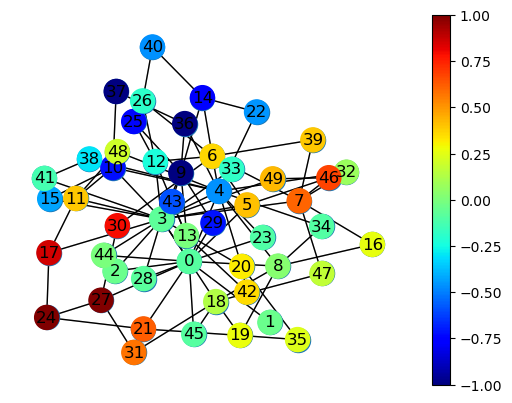

In [8]:
seed, n, m = 0, 50, 2
g = nx.generators.random_graphs.barabasi_albert_graph(seed=seed, n=n, m=m)

model, _, _ = initialize_model(train_X=torch.zeros((0,1), dtype=torch.float),
                         train_Y=torch.zeros((0,1), dtype=torch.float),
                         context_graph=g,
                         covar_type="polynomial",
                         covar_kwargs = {"order": 10,},
                         ard=True)
t = torch.tensor(range(n), dtype=torch.float).reshape(-1,1)
model.eval()
dist = model(t)
pos = nx.kamada_kawai_layout(g)
pos = nx.spring_layout(g)
nodes = g.nodes()

all_X = torch.tensor(range(n), dtype=torch.float)
t = all_X.reshape(-1,1)
model.eval()
dist = model(t)

all_Y = dist.sample().reshape(-1, 1)
print(all_Y)
print("beta:", model.covar_module.base_kernel.lengthscale)
# all_Y = eigenvecs[:, 0]
colors = all_Y
nx.draw_networkx(g, pos)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2, )
nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=colors, node_size=300, cmap=plt.cm.jet, vmin=-1,vmax=1)
plt.colorbar(nc)
plt.axis('off')
#plt.savefig( "realizations2.pdf",bbox_inches='tight')
plt.show()

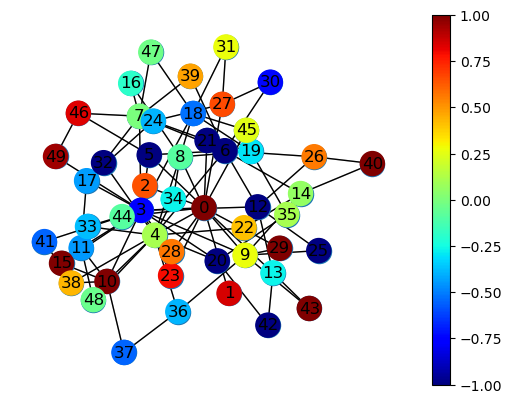

In [9]:
seed, n, m = 0, 50, 2
g = nx.generators.random_graphs.barabasi_albert_graph(seed=seed, n=n, m=m)

model, _, _ = initialize_model(train_X=torch.zeros((0,1), dtype=torch.float),
                         train_Y=torch.zeros((0,1), dtype=torch.float),
                         context_graph=g,
                         covar_type="polynomial",
                         covar_kwargs = {"order": 40,})
t = torch.tensor(range(n), dtype=torch.float).reshape(-1,1)
model.eval()
dist = model(t)
pos = nx.kamada_kawai_layout(g)
pos = nx.spring_layout(g)
nodes = g.nodes()

all_X = torch.tensor(range(n), dtype=torch.float)
t = all_X.reshape(-1,1)

model.eval()
dist = model(t)

all_Y = dist.sample().reshape(-1, 1)
# all_Y = eigenvecs[:, 0]
colors = all_Y
nx.draw_networkx(g, pos)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2, )
nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=colors, node_size=300, cmap=plt.cm.jet, vmin=-1,vmax=1)
plt.colorbar(nc)
plt.axis('off')
plt.savefig( "realizations.pdf",bbox_inches='tight')
plt.savefig( "realizations.png",bbox_inches='tight')
plt.show()

<class 'networkx.utils.decorators.argmap'> compilation 16:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/data/osselinp/miniconda3/envs/graph/lib/python3.10/site-packages/botorch/models/gpytorch.py:119: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(


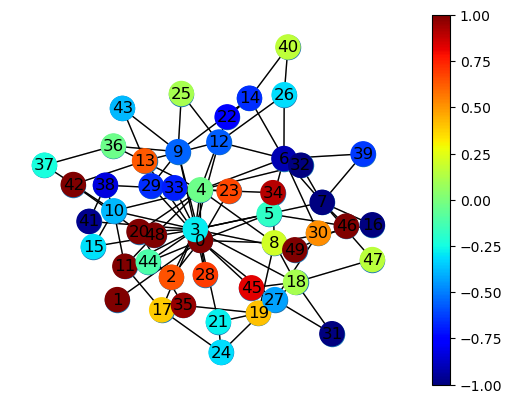

In [18]:
seed, n, m = 0, 50, 2
g = nx.generators.random_graphs.barabasi_albert_graph(seed=seed, n=n, m=m)

model, _, _ = initialize_model(train_X=torch.zeros((0,1), dtype=torch.float),
                         train_Y=torch.zeros((0,1), dtype=torch.float),
                         context_graph=g,
                         covar_type="polynomial",
                         covar_kwargs = {"order": 30,})
t = torch.tensor(range(n), dtype=torch.float).reshape(-1,1)
model.eval()
dist = model(t)
pos = nx.kamada_kawai_layout(g)
pos = nx.spring_layout(g)
nodes = g.nodes()

all_X = torch.tensor(range(n), dtype=torch.float)
t = all_X.reshape(-1,1)

model.eval()
dist = model(t)

all_Y = dist.sample().reshape(-1, 1)
# all_Y = eigenvecs[:, 0]
colors = all_Y
nx.draw_networkx(g, pos)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2, )
nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=colors, node_size=300, cmap=plt.cm.jet, vmin=-1,vmax=1)
plt.colorbar(nc)
plt.axis('off')
plt.savefig( "realizations2.pdf",bbox_inches='tight')
plt.show()

# Influence of Beta

tensor([[ 1.0996],
        [ 0.5274],
        [ 0.7485],
        [ 0.2951],
        [ 0.6052],
        [ 0.5080],
        [ 0.4402],
        [ 0.2779],
        [ 0.3460],
        [ 0.1419],
        [ 0.1043],
        [ 0.1790],
        [ 0.1523],
        [ 0.3802],
        [ 0.2880],
        [ 0.3900],
        [ 0.1376],
        [ 0.0211],
        [ 0.3476],
        [ 0.1569],
        [ 0.3542],
        [ 0.2949],
        [ 0.1320],
        [ 0.0897],
        [ 0.3311],
        [ 0.4410],
        [ 0.3367],
        [ 0.0158],
        [ 0.1350],
        [ 0.3198],
        [ 0.2008],
        [ 0.6650],
        [ 0.1717],
        [ 0.0722],
        [ 0.4304],
        [ 0.1137],
        [ 0.3720],
        [ 0.1601],
        [ 0.3266],
        [-0.0278],
        [ 0.2592],
        [ 0.3336],
        [ 0.3454],
        [ 0.1296],
        [ 0.0502],
        [ 0.0648],
        [ 0.3699],
        [ 0.2265],
        [ 0.1611],
        [ 0.1873]])
beta: tensor([[0.7000, 0.0100]], grad_fn=<AddBack

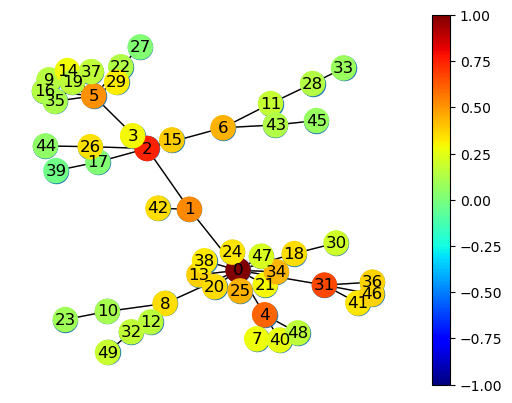

tensor([5.7597e-08, 8.7660e-03, 2.8714e-02, 4.4407e-02, 6.6987e-02, 6.7849e-02,
        1.0262e-01, 1.0607e-01, 1.4645e-01, 1.4645e-01, 1.6953e-01, 1.7165e-01,
        2.1068e-01, 2.8620e-01, 3.1081e-01, 3.7287e-01, 5.0000e-01, 5.0000e-01,
        5.0000e-01, 5.0000e-01, 5.0000e-01, 5.0000e-01, 5.0000e-01, 5.0000e-01,
        5.0000e-01, 5.0000e-01, 5.0000e-01, 5.0000e-01, 5.0000e-01, 5.0000e-01,
        5.0000e-01, 5.0000e-01, 5.0000e-01, 5.0000e-01, 6.2713e-01, 6.8919e-01,
        7.1380e-01, 7.8932e-01, 8.2835e-01, 8.3047e-01, 8.5355e-01, 8.5355e-01,
        8.9393e-01, 8.9738e-01, 9.3215e-01, 9.3301e-01, 9.5559e-01, 9.7129e-01,
        9.9123e-01, 1.0000e+00])


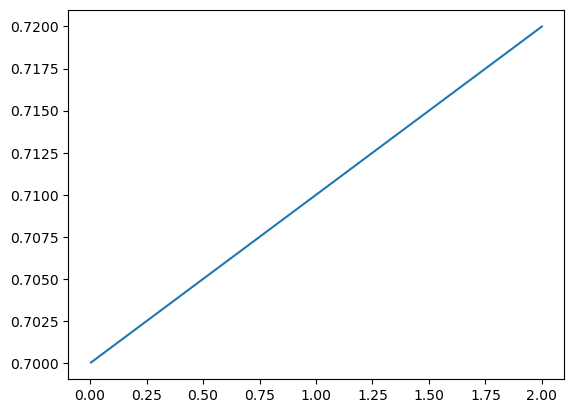

In [93]:
seed, n, m = 0, 50, 1
g = nx.generators.random_graphs.barabasi_albert_graph(seed=seed, n=n, m=m)

model, _, _ = initialize_model(train_X=torch.zeros((0,1), dtype=torch.float),
                         train_Y=torch.zeros((0,1), dtype=torch.float),
                         context_graph=g,
                         covar_type="polynomial",
                         covar_kwargs = {"order": 2,},
                         ard=True)
t = torch.tensor(range(n), dtype=torch.float).reshape(-1,1)
model.covar_module.base_kernel.lengthscale = torch.tensor([[0.7, 1e-2]])
model.eval()
dist = model(t)
pos = nx.kamada_kawai_layout(g)
pos = nx.spring_layout(g)
nodes = g.nodes()

all_X = torch.tensor(range(n), dtype=torch.float)
t = all_X.reshape(-1,1)

model.eval()
dist = model(t)

all_Y = dist.sample().reshape(-1, 1)
print(all_Y)
print("beta:", model.covar_module.base_kernel.lengthscale)
# all_Y = eigenvecs[:, 0]
colors = all_Y
nx.draw_networkx(g, pos)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2, )
nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=colors, node_size=300, cmap=plt.cm.jet, vmin=-1,vmax=1)
plt.colorbar(nc)
plt.axis('off')
plt.savefig( "realizations_beta1e-1.png",bbox_inches='tight')
plt.show()


x = torch.linspace(0,2,500)[1:]
result = torch.zeros(499)
for i in range(model.covar_module.base_kernel.order):
    result += model.covar_module.base_kernel.lengthscale[0][i] * x**i
plt.plot(x.detach().numpy(), result.detach().numpy())
plt.savefig("realizations_rbeta1e-1.png",bbox_inches='tight')
print(model.covar_module.base_kernel.eigenvalues)

In [36]:
#plot r


tensor([5.8457e-07, 1.1261e-01, 1.2839e-01, 1.4688e-01, 1.7074e-01, 1.9001e-01,
        2.0930e-01, 2.4383e-01, 2.6236e-01, 2.6376e-01, 2.7359e-01, 3.0031e-01,
        3.1553e-01, 3.2354e-01, 3.4242e-01, 3.7187e-01, 3.7599e-01, 4.0005e-01,
        4.1998e-01, 4.3627e-01, 4.5336e-01, 5.0000e-01, 5.0000e-01, 5.0000e-01,
        5.0000e-01, 5.0000e-01, 5.0000e-01, 5.0000e-01, 5.0000e-01, 5.3905e-01,
        5.6090e-01, 5.7087e-01, 6.0128e-01, 6.2992e-01, 6.5127e-01, 6.6171e-01,
        6.9164e-01, 6.9637e-01, 7.0663e-01, 7.2115e-01, 7.5037e-01, 7.6449e-01,
        7.7766e-01, 7.9183e-01, 8.1380e-01, 8.3791e-01, 8.5398e-01, 8.6226e-01,
        8.8028e-01, 8.9586e-01])

In [ ]:
epsilon = 1e-6
eigen_powered = torch.stack(
    [self.eigenvalues ** i for i in range(self.order)]
)

dists = 1. / (torch.einsum("ij,i->ij", eigen_powered,
                            self.lengthscale.squeeze(0)) + epsilon)
dists = torch.diag(dists.sum(0).squeeze())
dists *= self.eigenvalues.shape[0] / torch.sum(dists)
return dists

2

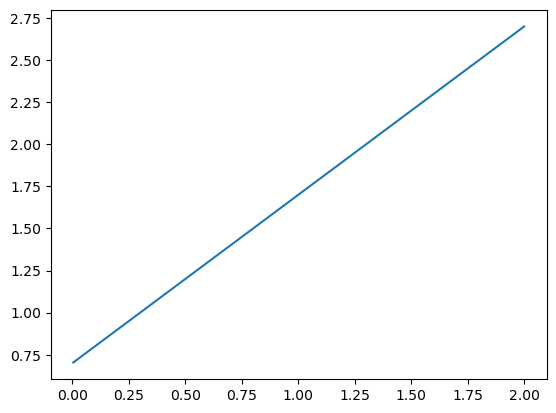

In [33]:
x = torch.linspace(0,2,500)[1:]
result = torch.zeros(499)
for i in range(model.covar_module.base_kernel.order):
    result += model.covar_module.base_kernel.lengthscale[0][i] * x**i
plt.plot(x.detach().numpy(), result.detach().numpy())

In [31]:
model.covar_module.base_kernel.lengthscale

tensor([[0.7000, 1.0000]], grad_fn=<AddBackward0>)

In [23]:
torch.zeros(499)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [54]:
nx.draw(g)


TypeError: '_AxesStack' object is not callable

<Figure size 640x480 with 0 Axes>

In [58]:
import matplotlib.pyplot as plt
nx.draw(g)

TypeError: '_AxesStack' object is not callable

<Figure size 640x480 with 0 Axes>

In [59]:
g = nx.generators.random_graphs.barabasi_albert_graph(seed=seed, n=n, m=m)

In [60]:
g

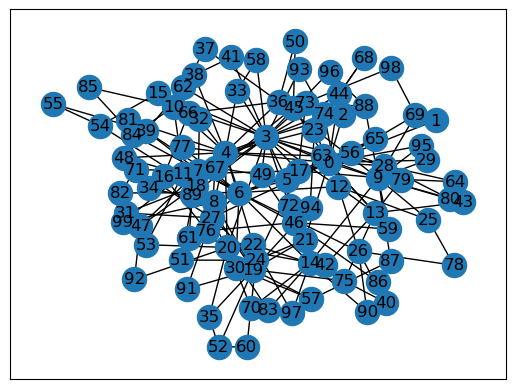

In [62]:
nx.draw_networkx(g)